In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=16,family='serif')
import matplotlib.gridspec as gridspec
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from multiprocessing import cpu_count, Pool
from corner import corner
from Cosmology import *
import sys

#Cosmological parameters
Omega_m = 0.3089
Omega_c = 0.6911

# Import data

## Supernova data

In [2]:
dataSN = np.loadtxt('data/jla_lcparams.txt', usecols=(2,4,6,8,10))
errSN = np.loadtxt('data/jla_lcparams.txt', usecols=(5,7,9))[np.argsort(dataSN.T[0])]
dataSN = dataSN[np.argsort(dataSN.T[0])]

#best fit values found in JLA analysis arXiv:1401.4064
a = 0.14
b = 3.14
MB = -19.04
delta_Mhost = -.06

In [3]:
SNdata = Supernova_data(dataSN, errSN, np.array([a,b,MB, 0]))

## Quasar data

In [4]:
dataQ = np.loadtxt('data/quasar_data_RL.txt', usecols=(0,1,2,3,4))
errQ = np.loadtxt('data/quasar_data_RL.txt', usecols=5)[np.argsort(dataQ.T[0])]
dataQ = dataQ[np.argsort(dataQ.T[0])]

#best fit values found in Risaliti & Lusso, Nature Astronomy, 2018
beta_prime, s = 7.4, 1.5

In [5]:
Qdata = Quasar_data(dataQ, errQ, np.array([beta_prime, s]))

# Set up and run the MCMC sampler [arXiv:1202.3665]

## Define the likelihood and priors

In [139]:
def lnlike(theta, SNdata, Qdata):
    if len(theta) == 9:
        Omegam, Omegac, w, a, b, MB, delta_Mhost, beta_prime, s = theta
        cosmo = cosmology(Omegam, Omegac, w)
    elif len(theta) == 8:
        Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
        cosmo = cosmology(Omegam, Omegac)
    
    SNdata.set_param(np.array([a,b,MB, delta_Mhost]))
    Qdata.set_param(np.array([beta_prime, s]))
    
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
    log_prob += cosmo.log_likelihood(Qdata.distance_modulus(), Qdata.delta_distance_modulus())
    
    if np.isnan(log_prob):
        return -np.inf
    
    
    return log_prob


def lnprior(theta):
    Omegam, Omegac, w, a, b, MB, delta_Mhost, beta_prime, s = theta
    #flat priors:
    if 0 < Omegam < 1.0 and 0 < Omegac < 1.5 and -3 < w < -1/3. and -5 <= a < 5 and -10 < b < 10 and -25 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < beta_prime < 10 and 0 < s <= 3:
        return 0.0
    return -np.inf

def lnprob(theta, SNdata, Qdata):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, SNdata, Qdata)

## set up and run the MC sampler locally...
## (uncomment this cell if you want to load a preexisting chain)

In [140]:
ndim, nwalkers, nsteps = 9, 20, 100
pos0 = [np.array([Omega_m, Omega_c, -1, a, b, MB, 0, beta_prime, s]) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #, .2, 2, .1, -20]])

pool = Pool(cpu_count())
write = HDFBackend('results/wLCDM_' + str(nwalkers) + 'x' + str(nsteps) + '.h5')
sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(SNdata, Qdata), pool=pool)#, backend=write)


tau, accepted = [], []

# Now we'll sample for up to nsteps steps
for i, sample in enumerate(sampler.sample(pos0, iterations=nsteps, progress=True)):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau.append(np.mean(sampler.get_autocorr_time(tol=0)))
    accepted.append(np.mean(sampler.acceptance_fraction))
pool.close()

KeyboardInterrupt: 

emcee: Exception while calling your likelihood function:
  params: [  0.3290843    0.50847155  -0.99264721   0.06088283   3.23465619
 -18.93610663   0.12778242   7.46796838   1.66928998]
  args: (<Cosmology.Supernova_data object at 0x7ff1670eec18>, <Cosmology.Quasar_data object at 0x7ff154d9e978>)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)
  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())


emcee: Exception while calling your likelihood function:
  params: [  0.19107906   0.70958808  -0.99254918   0.14954461   3.27339138
 -19.18002655   0.08915966   7.4671789    1.45138347]

  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 87, in log_likelihood
    Cov_inv = np.linalg.inv(Cov)


emcee: Exception while calling your likelihood function:


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)



  params: [  0.28977848   0.84298456  -0.92325099   0.01920349   3.20633427
 -19.05939346   0.05864643   7.57116032   1.39647972]

KeyboardInterrupt


  args: (<Cosmology.Supernova_data object at 0x7ff155339da0>, <Cosmology.Quasar_data object at 0x7ff14d1a0828>)



Process ForkPoolWorker-13:


  kwargs: {}


Traceback (most recent call last):


  args: (<Cosmology.Supernova_data object at 0x7ff155a65898>, <Cosmology.Quasar_data object at 0x7ff14d1a4eb8>)
  exception:
  kwargs: {}


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):


  exception:


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)


emcee: Exception while calling your likelihood function:


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)


  params: [  0.10901938   0.58424697  -0.88202424   0.15169471   3.20853942
 -19.02269574   0.03914562   7.54342482   1.51815745]

  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)


  args: (<Cosmology.Supernova_data object at 0x7ff154d9ec88>, <Cosmology.Quasar_data object at 0x7ff14d1938d0>)


  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 87, in log_likelihood
    Cov_inv = np.linalg.inv(Cov)
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)


  kwargs: {}


  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 87, in log_likelihood
    Cov_inv = np.linalg.inv(Cov)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 87, in log_likelihood
    Cov_inv = np.linalg.inv(Cov)
KeyboardInterrupt
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  Fi

  exception:


Process ForkPoolWorker-18:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  params: [  0.30786649   0.71226074  -1.04633055   0.16108065   3.2931454
 -19.00605922  -0.05162398   7.55944197   1.55122828]

  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)
  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File

  args: (<Cosmology.Supernova_data object at 0x7ff154f5a780>, <Cosmology.Quasar_data object at 0x7ff14d1937b8>)


  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
KeyboardInterrupt
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)


  kwargs: {}


KeyboardInterrupt
  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 87, in log_likelihood
    Cov_inv = np.linalg.inv(Cov)


  exception:


Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)
Process ForkPoolWorker-17:
Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **k

emcee: Exception while calling your likelihood function:
  params: [  0.27425135   0.75631043  -1.01313909   0.07074277   3.20156914
 -18.9843276   -0.18644511   7.3810521    1.54005359]
  args: (<Cosmology.Supernova_data object at 0x7ff1670ee208>, <Cosmology.Quasar_data object at 0x7ff154d9e860>)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/ensemble.py", line 499, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-139-c4829bc291c8>", line 33, in lnprob
    return lp + lnlike(theta, SNdata, Qdata)
  File "<ipython-input-139-c4829bc291c8>", line 12, in lnlike
    log_prob = cosmo.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
  File "/home/lin/moritz/ownCloud/PostDoc/COSMOLOGY/cosmological_tests/Cosmology.py", line 88, in log_likelihood
    Cov_eigvals = np.linalg.eigvalsh(Cov)
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1170, in eigvalsh
    w = gufunc(a, signature=signature, extobj=extobj)
KeyboardInterrupt
Process ForkPoolWorker-14:
Traceback (most recent call last):
  File "/home/lin/moritz/anaconda3/envs/emcee3/lib/python3.6/multiprocessing/process.py", line 258, 

# Load $\Lambda$LCDM data

In [109]:
LCDM_sampler = HDFBackend('results/LCDM_500x1000.h5', read_only=True)

nsteps, nwalkers, ndim = LCDM_sampler.get_chain().shape
labs = [r'$\Omega_m$', r'$\Omega_\Lambda$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

## Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/30$

In [114]:
Nmin = 0
while Nmin < nsteps and np.all(LCDM_sampler.get_autocorr_time(tol=0,discard=Nmin)/(nsteps)*30 > 1):
    Nmin+=100
    
print('Nmin = {}'.format(Nmin))

Nmin = 500


<IPython.core.display.Javascript object>


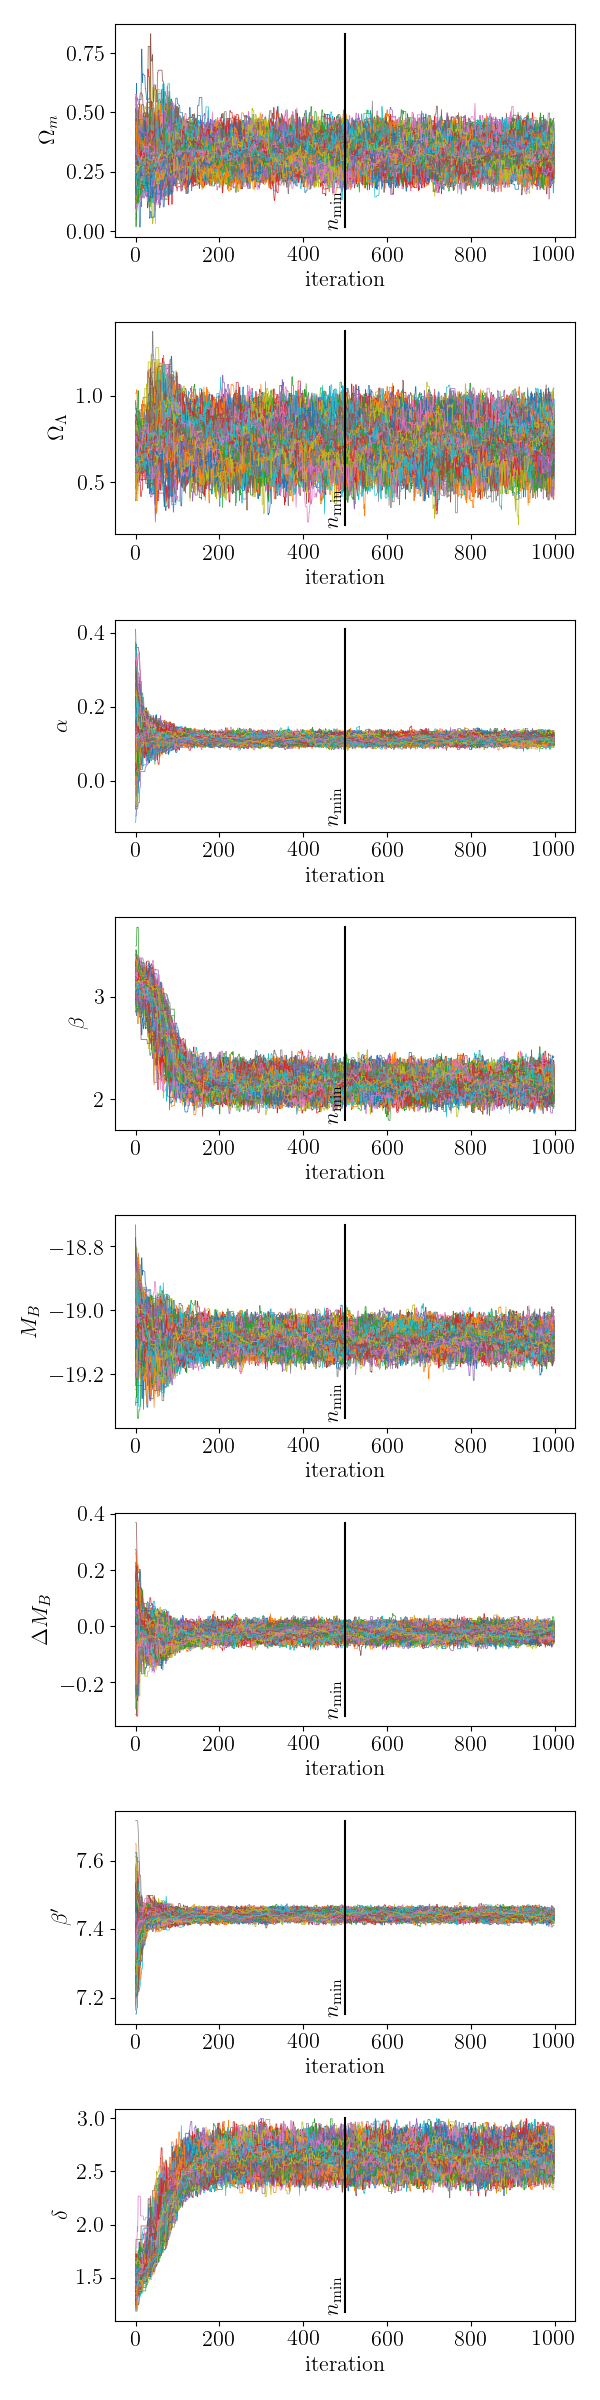

In [115]:
LCDM_samples = LCDM_sampler.get_chain()

f, ax = plt.subplots(len(LCDM_samples.T), 1, figsize=(6,3*len(LCDM_samples.T)))

for i in range(len(LCDM_samples.T)):
    ax[i].plot(LCDM_samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(LCDM_samples.T[i].flatten()), max(LCDM_samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(LCDM_samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
plt.savefig('plots/convergence_LCDM.pdf')
plt.show()

## Plot the 1$\sigma$ and 2$\sigma$ contours

<IPython.core.display.Javascript object>


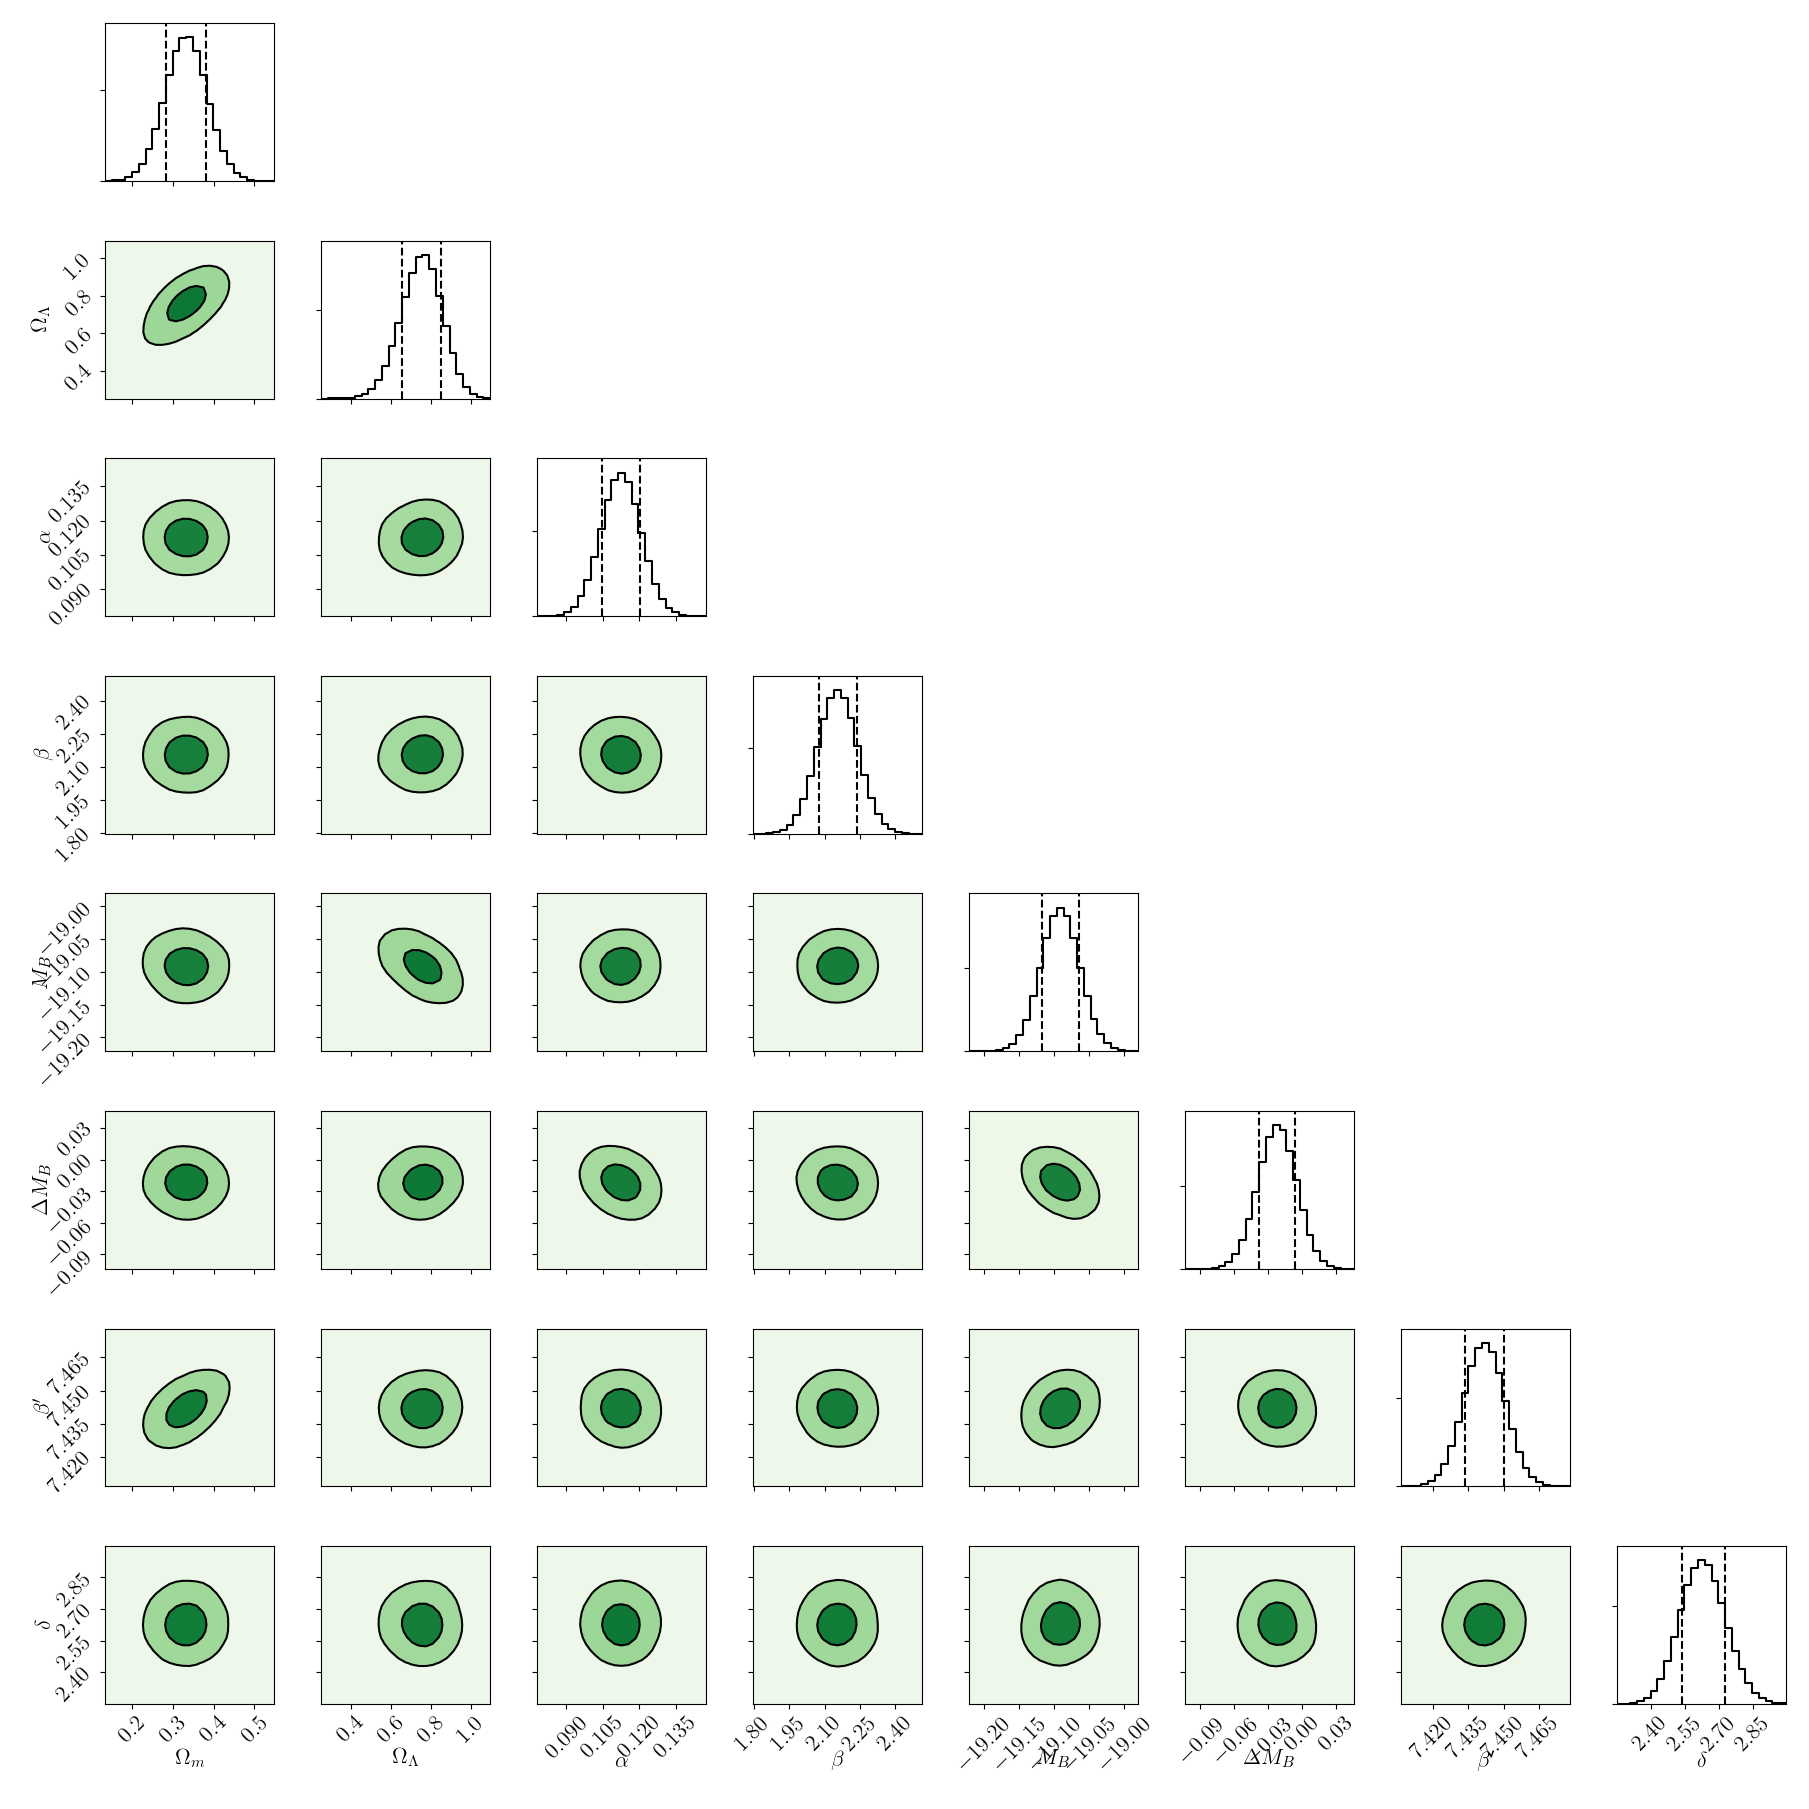

In [123]:
LCDM_samples = LCDM_sampler.get_chain()[Nmin:, :, :].reshape((-1, ndim))


meanLCDM = np.mean(LCDM_samples, axis=0)
stdLCDM = np.var(LCDM_samples, axis=0)
maxLCDM=[]
for i in range(len(meanLCDM)):
    likelihood = np.histogram(LCDM_samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxLCDM.append(max_val)


fig = corner(LCDM_samples, quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'))#,
# #              truths=maxLCDM)

plt.tight_layout()
plt.savefig('plots/posterior_LCDM.pdf')

## Visualize the results

In [132]:
v = np.percentile(LCDM_samples,[16, 50, 84], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo_LCDM = cosmology(*maxLCDM[:2])

<IPython.core.display.Javascript object>


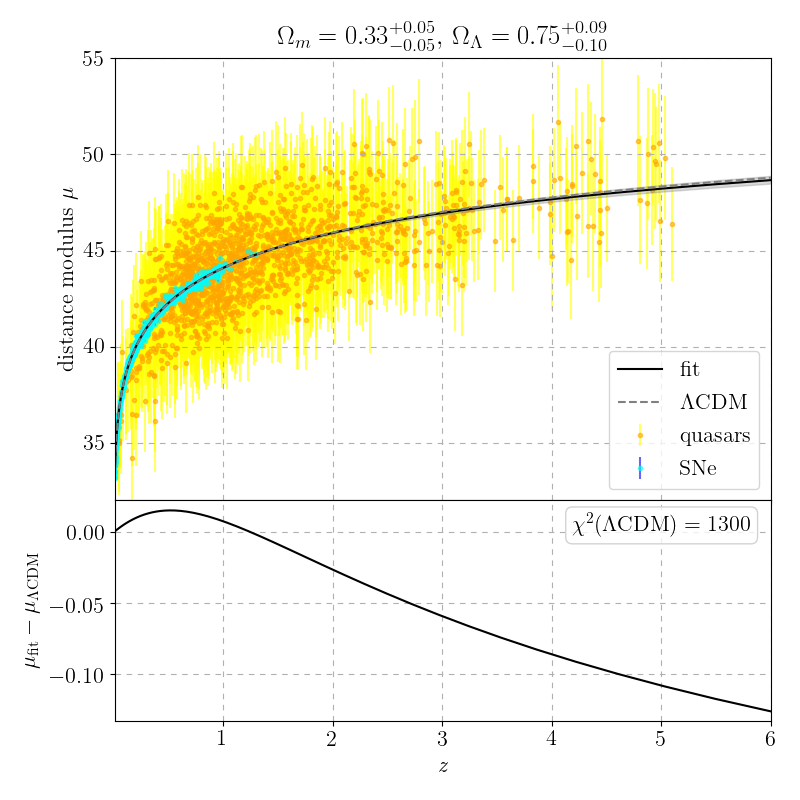

In [143]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=Qdata.delta_distance_modulus(), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')




zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, best_fit_cosmo_LCDM.distance_modulus(zPlot), c='k', label=r'fit')
ax1.fill_between(zPlot, cosmology(omegam+stdmp,omegac+stdcp).distance_modulus(zPlot), cosmology(omegam-stdmm,omegac-stdcm).distance_modulus(zPlot), color='gray', alpha=0.3)
ax1.plot(zPlot, cosmology(Omega_m, Omega_c).distance_modulus(zPlot), ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, best_fit_cosmo_LCDM.distance_modulus(zPlot) - cosmology(Omega_m, Omega_c).distance_modulus(zPlot), 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\chi^2(\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(maxLCDM,SNdata,Qdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
plt.savefig('plots/Hubble_LCDM.pdf')
plt.show()

# Load $w\Lambda$LCDM data

In [144]:
wLCDM_sampler = HDFBackend('results/wLCDM_500x1000.h5', read_only=True)

nsteps, nwalkers, ndim = wLCDM_sampler.get_chain().shape
labs = [r'$\Omega_m$', r'$\Omega_\Lambda$', r'$w$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

## Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/30$

In [145]:
Nmin = 0
while Nmin < nsteps and np.all(wLCDM_sampler.get_autocorr_time(tol=0,discard=Nmin)/(nsteps)*30 > 1):
    Nmin+=100
    
print('Nmin = {}'.format(Nmin))

Nmin = 600


<IPython.core.display.Javascript object>


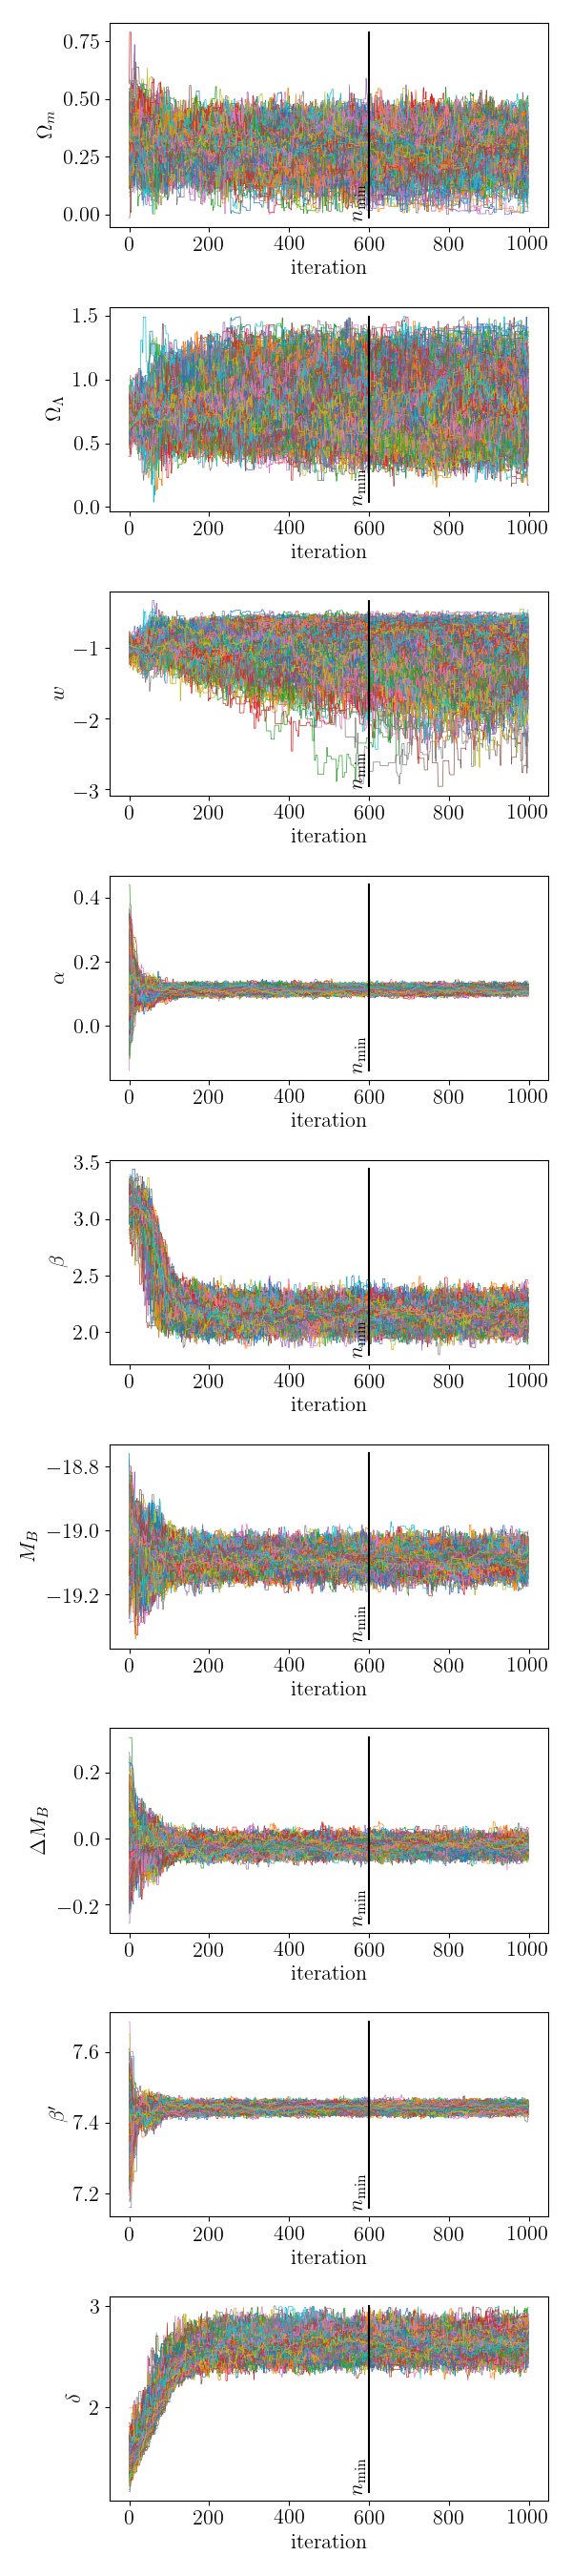

In [146]:
wLCDM_samples = wLCDM_sampler.get_chain()

f, ax = plt.subplots(len(wLCDM_samples.T), 1, figsize=(6,3*len(wLCDM_samples.T)))

for i in range(len(wLCDM_samples.T)):
    ax[i].plot(wLCDM_samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(wLCDM_samples.T[i].flatten()), max(wLCDM_samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(wLCDM_samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
plt.savefig('plots/convergence_wLCDM.pdf')
plt.show()

## Plot the 1$\sigma$ and 2$\sigma$ contours

<IPython.core.display.Javascript object>


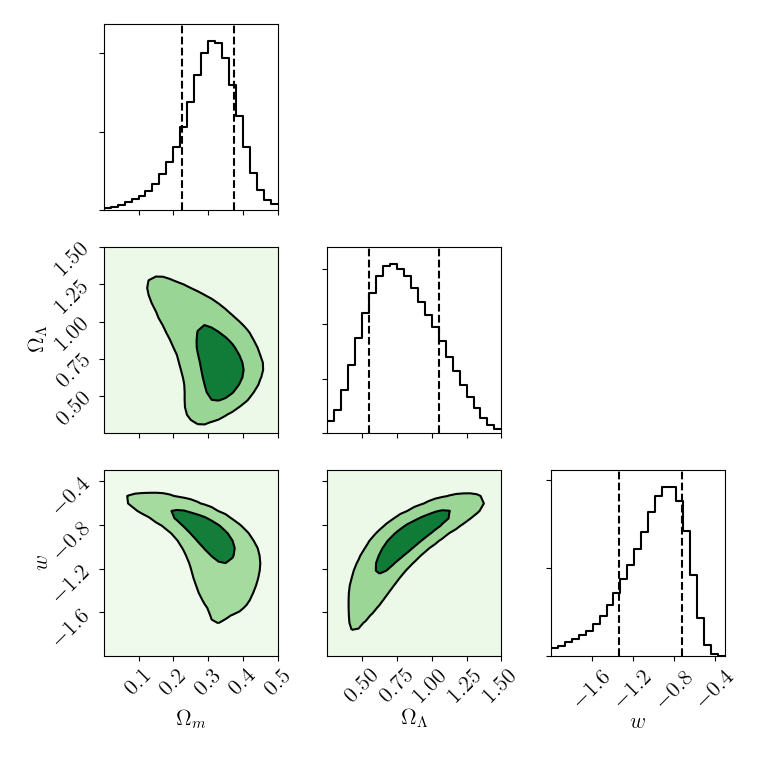

In [150]:
wLCDM_samples = wLCDM_sampler.get_chain()[Nmin:, :, :].reshape((-1, ndim))


meanwLCDM = np.mean(wLCDM_samples, axis=0)
stdwLCDM = np.var(wLCDM_samples, axis=0)
maxwLCDM=[]
for i in range(len(meanLCDM)):
    likelihood = np.histogram(wLCDM_samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxwLCDM.append(max_val)


fig = corner(wLCDM_samples[:,:3], quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)), range=[(0,.5), (.25,1.5), (-2.,-.3)],
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'))#,
#              truths=maxLCDM)

plt.tight_layout()
plt.savefig('plots/posterior_wLCDM_1.pdf')

<IPython.core.display.Javascript object>


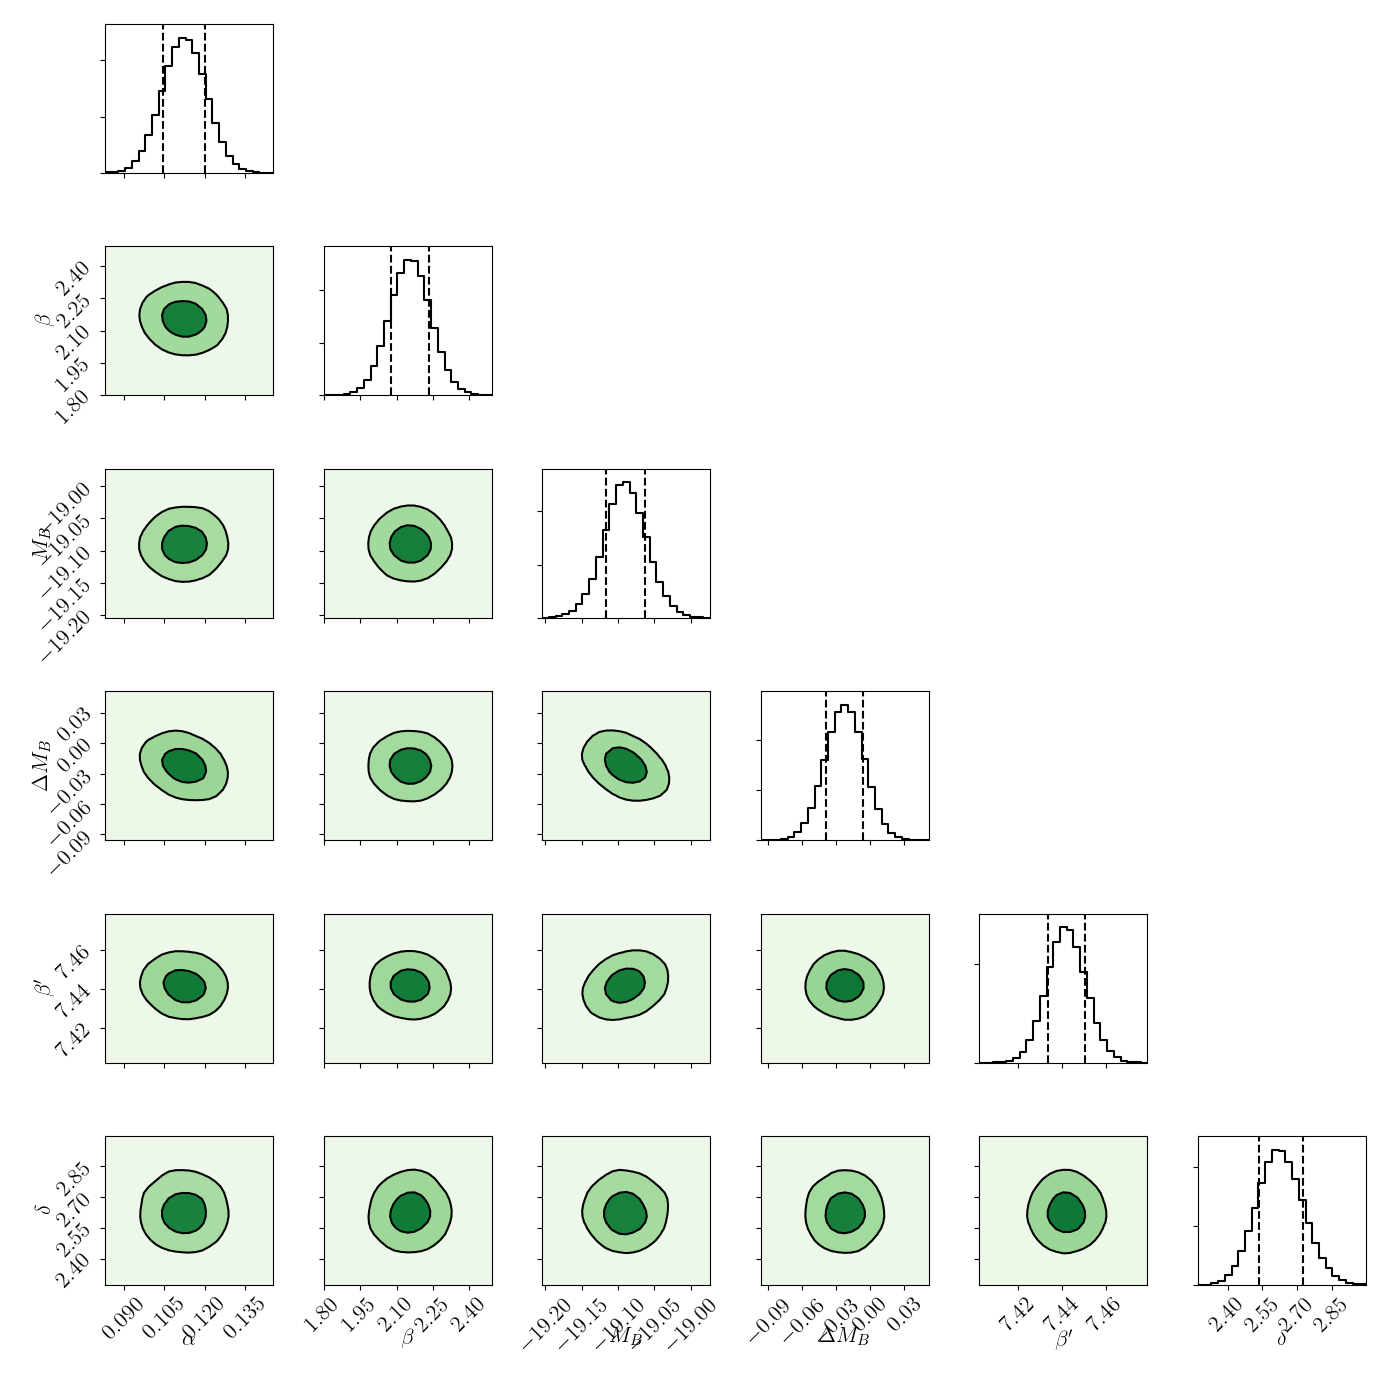

In [153]:
fig = corner(wLCDM_samples[:,3:], quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs[3:], smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'))#,
#              truths=maxLCDM)

plt.tight_layout()
plt.savefig('plots/posterior_wLCDM_2.pdf')

## Visualize the results

In [148]:
v = np.percentile(wLCDM_samples,[16, 50, 84], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]
w, wp, wm = v[2]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo = cosmology(*maxwLCDM[:3])

<IPython.core.display.Javascript object>


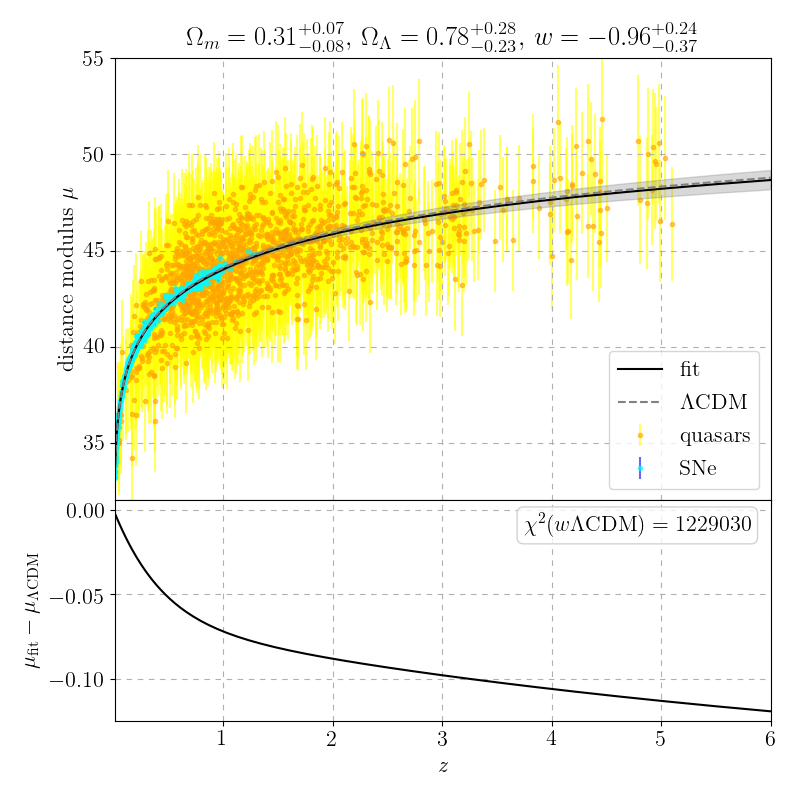

In [149]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f},\, w = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm, w, wp, wm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=Qdata.delta_distance_modulus(), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')




zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot), c='k', label=r'fit')
ax1.fill_between(zPlot, cosmology(omegam+stdmp,omegac+stdcp, w + wp).distance_modulus(zPlot), cosmology(omegam-stdmm,omegac-stdcm, w - wm).distance_modulus(zPlot), color='gray', alpha=0.3)
ax1.plot(zPlot, cosmology(Omega_m, Omega_c).distance_modulus(zPlot), ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot) - cosmology(Omega_m, Omega_c).distance_modulus(zPlot), 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\chi^2(w\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(maxwLCDM,SNdata,Qdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
plt.savefig('plots/Hubble_wLCDM.pdf')
plt.show()